In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model
"""from tensorflow.keras.preprocessing.image import ImageDataGenerator"""
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import sys
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import random as rn
%matplotlib inline

In [2]:
import os
os.environ['PYTHONHASHEED']='0'

In [12]:
np.random.seed(1234)

In [13]:
rn.seed(4321)

In [14]:
tf.random.set_seed(1324)

In [15]:
'''from keras import backend as K
sess=tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)'''

'from keras import backend as K\nsess=tf.Session(graph=tf.get_default_graph(), config=session_conf)\nK.set_session(sess)'

In [16]:
#einfach um zu schauen, dass tensorflow das GPU identifizieren kann - wenn 1, dann wurde es identifiziert
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices)) # print out number of GPUs available
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [19]:
#Organize data into train, valid, test dirs
os.chdir(r"C:\Users\ammasi\Desktop\data\covid")
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 3):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 100)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 50)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [20]:
train_path=r"C:\Users\ammasi\Desktop\data\covid\train"
valid_path=r"C:\Users\ammasi\Desktop\data\covid\valid"
test_path=r"C:\Users\ammasi\Desktop\data\covid\test"

In [21]:
'''train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=test_path, target_size=(224,224), batch_size=10)'''

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1289 images belonging to 3 classes.
Found 278 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


In [23]:
assert train_batches.n == 1289
assert valid_batches.n == 278
assert test_batches.n == 141
assert train_batches.num_classes == valid_batches.num_classes==test_batches.num_classes==3

In [24]:
surface=tf.keras.applications.mobilenet.MobileNet()

In [25]:
surface.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [26]:
'''params = count_params(mobile)
assert params['non-trainable_params'] == 21888
assert params['trainable_params'] == 4231976'''

"params = count_params(mobile)\nassert params['non-trainable_params'] == 21888\nassert params['trainable_params'] == 4231976"

## Modify Model

In [27]:
x = surface.layers[-6].output

In [28]:
output = Dense(units=3, activation='sigmoid')(x)

In [29]:
model = Model(inputs=surface.input, outputs=output)

In [30]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [32]:
'''loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)'''

'loss = tf.keras.losses.SparseCategoricalCrossentropy()\noptim = keras.optimizers.Adam(lr=0.001)\nmetrics = ["accuracy"]\n\nmodel.compile(loss=loss, optimizer=optim, metrics=metrics)'

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=2, verbose=2)

Epoch 1/2
129/129 - 27s - loss: 0.0630 - accuracy: 0.9837 - val_loss: 0.1965 - val_accuracy: 0.9317
Epoch 2/2
129/129 - 26s - loss: 0.0561 - accuracy: 0.9798 - val_loss: 0.1001 - val_accuracy: 0.9676


In [36]:
test_labels = test_batches.classes

In [37]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [38]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
test_batches.class_indices

{'0': 0, '1': 1, '2': 2}

Confusion matrix, without normalization
[[50  0  0]
 [ 3 47  0]
 [ 0  0 41]]


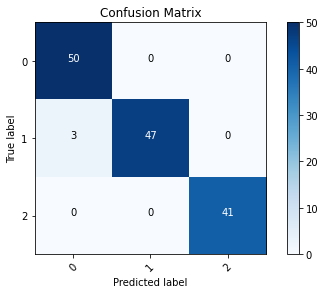

In [42]:
cm_plot_labels = ['0','1','2']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [29]:
test_batches.class_indices

{'0': 0, '1': 1}

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [3]:
model = Sequential([
    Dense(units=16, input_shape=(1,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='sigmoid')
])

In [4]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [5]:
model.fit(
    x=scaled_train_samples, 
    y=train_labels, 
    batch_size=10, 
    epochs=20, 
    shuffle=True, 
    verbose=2
)

NameError: name 'scaled_train_samples' is not defined